In [1]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow

In [ ]:
#credits: https://www.youtube.com/watch?v=qOXDoYUgNlU

Setting UP
1/1 [==============================] - 0s 19ms/step


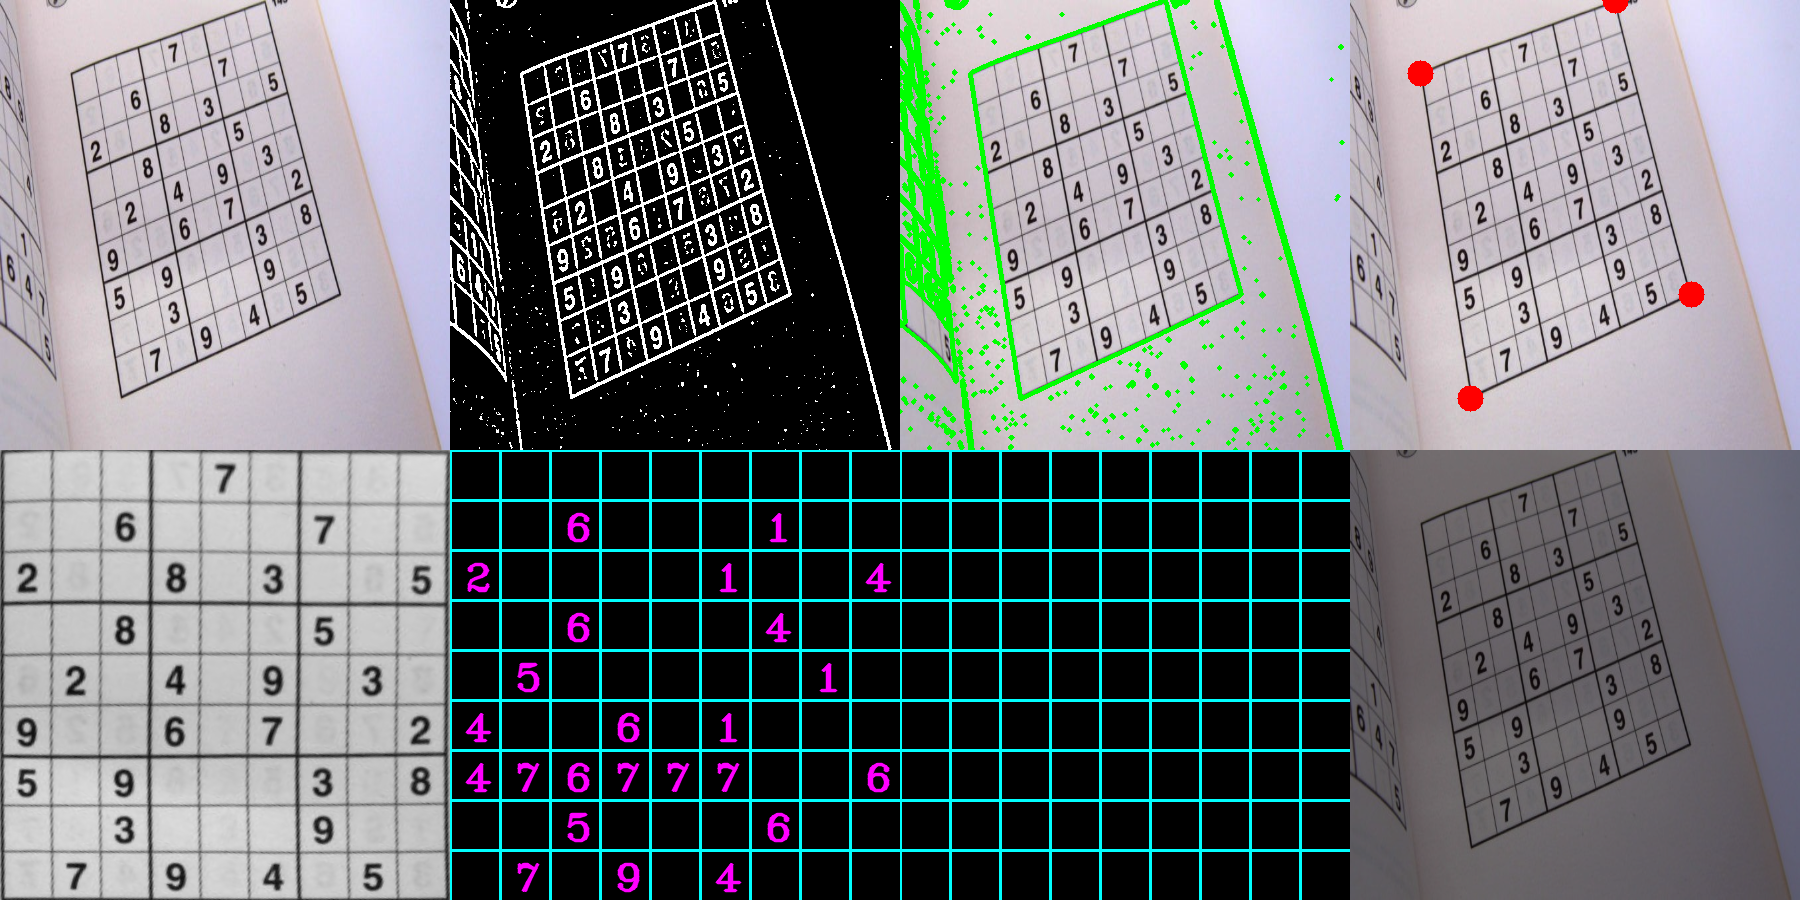

-1

In [157]:
print('Setting UP')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#from utlis import *
#import sudukoSolver

########################################################################
pathImage = "3.jpeg"
heightImg = 450
widthImg = 450
model = intializePredectionModel()  # LOAD THE CNN MODEL
########################################################################


#### 1. PREPARE THE IMAGE
img = cv2.imread(pathImage)
img = cv2.resize(img, (widthImg, heightImg))  # RESIZE IMAGE TO MAKE IT A SQUARE IMAGE
imgBlank = np.zeros((heightImg, widthImg, 3), np.uint8)  # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED
imgThreshold = preProcess(img)

# #### 2. FIND ALL COUNTOURS
imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 3) # DRAW ALL DETECTED CONTOURS

#### 3. FIND THE BIGGEST COUNTOUR AND USE IT AS SUDOKU

biggest, maxArea = biggestContour(contours) # FIND THE BIGGEST CONTOUR (sudoku rectangle)
#print(biggest)
if biggest.size != 0:
    biggest = reorder(biggest) #need the points to be in order of BL, BR, TL, TR
    #print(biggest)
    cv2.drawContours(imgBigContour, biggest, -1, (0, 0, 255), 25) # DRAW THE BIGGEST CONTOUR, to check if the sudoku rectangle is actually detected
    pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
    pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP, BL, BR, TL, TR
    matrix = cv2.getPerspectiveTransform(pts1, pts2) # GER, calculate transformation needed to transform image to square
    imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg)) #adjust image so sudoku is a square
    imgDetectedDigits = imgBlank.copy()
    imgWarpColored = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)

    #### 4. SPLIT THE IMAGE AND FIND EACH DIGIT AVAILABLE
    imgSolvedDigits = imgBlank.copy()
    boxes = splitBoxes(imgWarpColored)
    #print(len(boxes))
    # cv2.imshow("Sample",boxes[65])
    numbers = getPredection(boxes, model)
    #print(numbers)
    imgDetectedDigits = displayNumbers(imgDetectedDigits, numbers, color=(255, 0, 255))
    numbers = np.asarray(numbers)
    posArray = np.where(numbers > 0, 0, 1) #find where the numbers are empty
    #print(posArray)

    #### 5. FIND SOLUTION OF THE BOARD
    board = np.array_split(numbers,9)
    #print(board)
    try:
        solve(board)
    except:
        pass
    #print(board)
    flatList = []
    for sublist in board:
        for item in sublist:
            flatList.append(item)
    solvedNumbers =flatList*posArray
    imgSolvedDigits= displayNumbers(imgSolvedDigits,solvedNumbers)

    # #### 6. OVERLAY SOLUTION
    pts2 = np.float32(biggest) # PREPARE POINTS FOR WARP
    pts1 =  np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
    matrix = cv2.getPerspectiveTransform(pts1, pts2)  # GER
    imgInvWarpColored = img.copy()
    imgInvWarpColored = cv2.warpPerspective(imgSolvedDigits, matrix, (widthImg, heightImg))
    inv_perspective = cv2.addWeighted(imgInvWarpColored, 1, img, 0.5, 1)
    imgDetectedDigits = drawGrid(imgDetectedDigits)
    imgSolvedDigits = drawGrid(imgSolvedDigits)

    imageArray = ([img,imgThreshold,imgContours, imgBigContour],
                  [imgWarpColored, imgDetectedDigits,imgSolvedDigits,inv_perspective])
    stackedImage = stackImages(imageArray, 1)
    #cv2.imshow('Stacked Images', stackedImage)
    cv2_imshow(stackedImage)

else:
    print("No Sudoku Found")

cv2.waitKey(0)

In [156]:
def intializePredectionModel():
    model = load_model('DigitsRecognitionModel.h5')
    return model


#### 1 - Preprocessing Image
def preProcess(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # CONVERT IMAGE TO GRAY SCALE, src image, color conversion code
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)  # ADD GAUSSIAN BLUR, src, kernel size, gaussain kernel SD in x-axis
    imgThreshold = cv2.adaptiveThreshold(imgBlur, 255, 1, 1, 11, 2)  # APPLY ADAPTIVE THRESHOLD (used when have different lighting, so threshold not same)
    return imgThreshold


#### 3 - Reorder points for Warp Perspective
def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32) #need 3x3 image due to transformation matrix requirement in warpPerspective
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)] #Bottom left
    myPointsNew[3] =myPoints[np.argmax(add)] #Top Right
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)] #Bottom Right
    myPointsNew[2] = myPoints[np.argmax(diff)] #Top left
    return myPointsNew


#### 3 - FINDING THE BIGGEST COUNTOUR ASSUING THAT IS THE SUDUKO PUZZLE
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True) #perimeter
            approx = cv2.approxPolyDP(i, 0.02 * peri, True) #find number of corners, 0.02*peri is our epsilon
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest,max_area


#### 4 - TO SPLIT THE IMAGE INTO 81 DIFFRENT IMAGES
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes


#### 4 - GET PREDECTIONS ON ALL IMAGES
def getPredection(boxes,model):
    result = []
    for image in boxes:
        # copy = image.copy()
        # cv2_imshow(copy)
        # gray = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)[1]
        # cnt = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        # cv2.drawContours(copy, cnt, -1, (255, 255, 0), 3)
        # print(cnt)
        #cv2_imshow(image)
        ## PREPARE IMAGE
        img = np.asarray(image)
        #print(img)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        #img = img[4:img.shape[0] - 4, 4:img.shape[1] -8]
        #print(img)
        img = cv2.resize(img, (28, 28))
        img = img / 255
        #print(img.shape)
        img = img.reshape(1, 28, 28, 1)
        #print(img.shape)
        ## GET PREDICTION
        predictions = model.predict(img)
        classIndex = np.argmax(predictions,axis=-1) #find index of max value
        #classIndex = model.predict_classes(img)
        probabilityValue = np.amax(predictions)
        #print(predictions)
        ## SAVE TO RESULT
        if probabilityValue > 0.8:
            result.append(classIndex[0])
        else:
            result.append(0)
        #print(classIndex[0])
        #break
    return result


#### 6 -  TO DISPLAY THE SOLUTION ON THE IMAGE
def displayNumbers(img,numbers,color = (0,255,0)):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            if numbers[(y*9)+x] != 0 :
                 cv2.putText(img, str(numbers[(y*9)+x]),
                               (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv2.LINE_AA)
    return img


#### 6 - DRAW GRID TO SEE THE WARP PRESPECTIVE EFFICENCY (OPTIONAL)
def drawGrid(img):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for i in range (0,9):
        pt1 = (0,secH*i)
        pt2 = (img.shape[1],secH*i)
        pt3 = (secW * i, 0)
        pt4 = (secW*i,img.shape[0])
        cv2.line(img, pt1, pt2, (255, 255, 0),2)
        cv2.line(img, pt3, pt4, (255, 255, 0),2)
    return img


#### 6 - TO STACK ALL THE IMAGES IN ONE WINDOW
def stackImages(imgArray,scale):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
            hor_con[x] = np.concatenate(imgArray[x])
        ver = np.vstack(hor)
        ver_con = np.concatenate(hor)
    else:
        for x in range(0, rows):
            imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        hor_con= np.concatenate(imgArray)
        ver = hor
    return ver

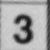

[[176 175 176 ... 164 162 166]
 [196 192 191 ... 190 187 186]
 [201 201 201 ... 202 203 204]
 ...
 [198 199 199 ... 202 202 203]
 [197 198 200 ... 202 201 200]
 [196 199 202 ... 202 200 200]]
1/1 [==============================] - 0s 19ms/step
[[7.0240780e-10 6.7518771e-01 2.8443468e-01 9.2192137e-10 7.4143733e-11
  4.0322915e-02 7.7048234e-10 7.7558910e-19 4.3300736e-07 5.4380693e-05]]


[0]

In [153]:
getPredection(boxes, model)

In [3]:
def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find
    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i
            if solve(bo):
                return True
            bo[row][col] = 0
    return False

def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False
    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False
    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False
    return True

def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")
        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")
            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col
    return None